# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

During the competition, I took into account the enlightments provided by others kernels, and included a few features that appeared to be important. In particular, I closely looked at the following kernels (ordered by release time):
1.  [You're Going to Want More Categories [LB 3.737] by Peter Hurford](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)
2. [EloDA with Feature Engineering and Stacking by Bojan Tunguz](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)
3. [A Closer Look at Date Variables by Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)
4. [LGB + FE (LB 3.707) by Konrad Banachewicz](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)
5. [My first kernel (3.699) by Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def fillna_with_mode(df):
    """
    Fill NaN values in a DataFrame with the respective column mode (assuming mode is always available).

    Parameters:
    - df: pandas DataFrame

    Returns:
    - DataFrame with NaN values filled with mode
    """
    return df.apply(lambda col: col.fillna(col.mode()[0]), axis=0)

In [4]:
e = pd.read_excel('/kaggle/input/elo-merchant-category-recommendation/Data Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [5]:
new_transactions = pd.read_csv('/kaggle/input/elo-merchant-category-recommendation/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('/kaggle/input/elo-merchant-category-recommendation/historical_transactions.csv',
                                      parse_dates=['purchase_date'])


def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
historical_transactions = fillna_with_mode(historical_transactions )
new_transactions = binarize(new_transactions)
new_transactions = fillna_with_mode(new_transactions )

We then load the main files, formatting the dates and extracting the target:

In [6]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df = fillna_with_mode(df)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'], format='%Y-%m')
    reference_date = pd.to_datetime('2018-11-27', format='%Y-%m-%d')
    df['elapsed_time'] = (reference_date - df['first_active_month']).dt.days
    return df
#_________________________________________
train = read_data('/kaggle/input/elo-merchant-category-recommendation/train.csv')
test = read_data('/kaggle/input/elo-merchant-category-recommendation/test.csv')


In [7]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,544
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,695
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,848
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,452
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,391


**EDA**

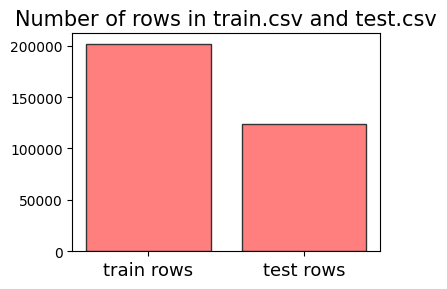

In [8]:
plt.figure(figsize=[4,3])
plt.bar([0, 1], [train.shape[0], test.shape[0]], edgecolor=[0.2]*3, color=(1,0,0,0.5))
plt.xticks([0,1], ['train rows', 'test rows'], fontsize=13)
plt.title('Number of rows in train.csv and test.csv', fontsize=15)
plt.tight_layout()
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int64         
 3   feature_2           201917 non-null  int64         
 4   feature_3           201917 non-null  int64         
 5   target              201917 non-null  float64       
 6   elapsed_time        201917 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


In [10]:
train.describe()

,first_active_month,feature_1,feature_2,feature_3,target,elapsed_time
count,201917,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000
mean,2017-01-15 00:30:16.001624320,3.105311,1.745410,0.565569,-0.393636,680.978981
min,2011-11-01 00:00:00,1.000000,1.000000,0.000000,-33.219281,299.000000
25%,2016-10-01 00:00:00,2.000000,1.000000,0.000000,-0.883110,452.000000
50%,2017-04-01 00:00:00,3.000000,2.000000,1.000000,-0.023437,605.000000
75%,2017-09-01 00:00:00,4.000000,2.000000,1.000000,0.765453,787.000000
max,2018-02-01 00:00:00,5.000000,3.000000,1.000000,17.965068,2583.000000
std,NaN,1.186160,0.751362,0.495683,3.850500,293.710176


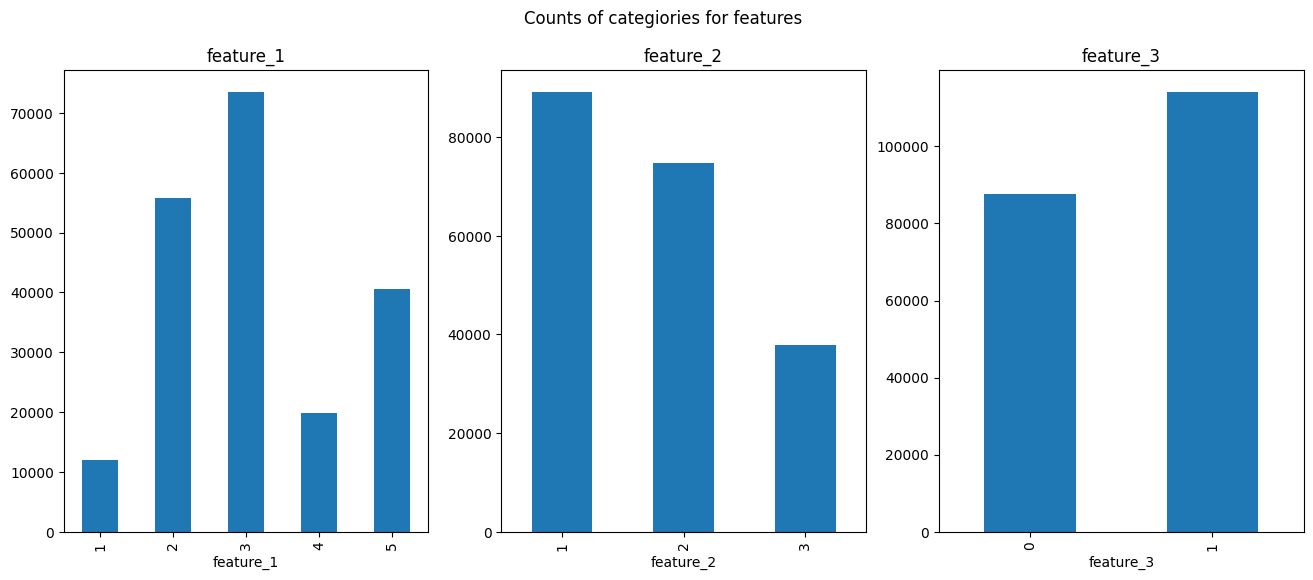

In [11]:
fig, ax = plt.subplots(1,3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], title='feature_3');
plt.suptitle('Counts of categiories for features');

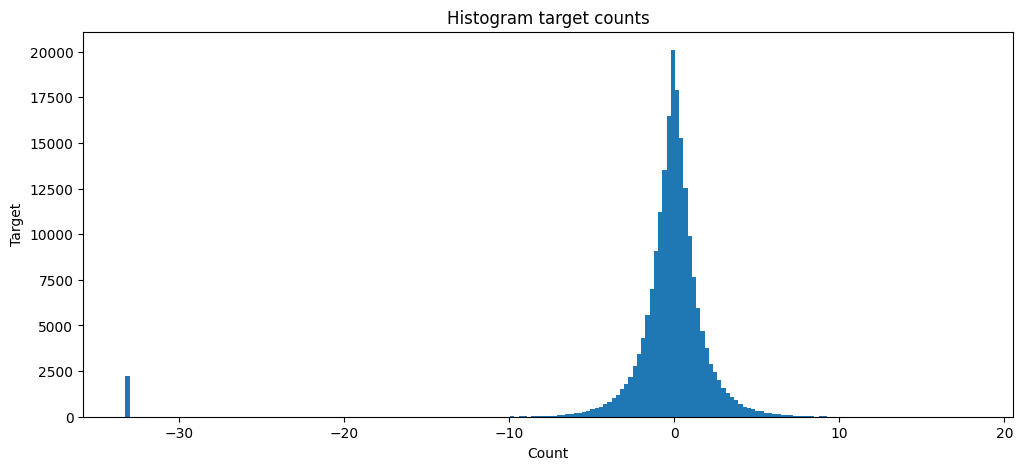

There are 2207 samples in the target equal to -33.21928095.


In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()
print(f'There are {train.loc[train.target  == min(train.target)].shape[0]} samples in the target equal to {min(train.target)}.')

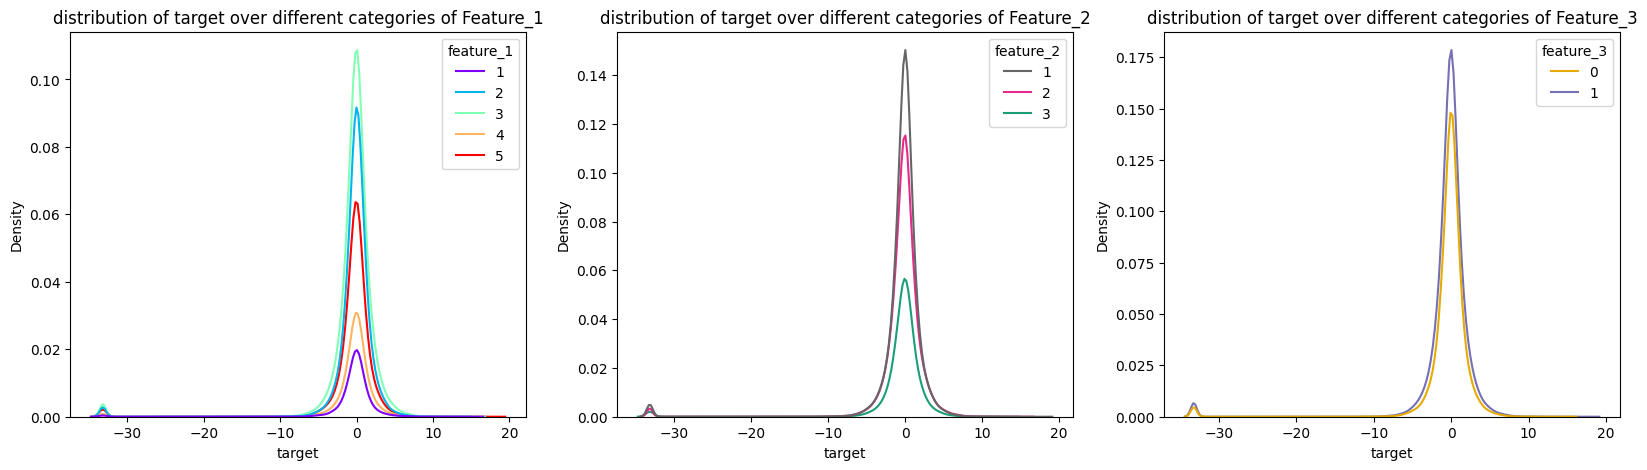

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.kdeplot(x ='target',data = train,hue = 'feature_1',palette='rainbow')
plt.title('distribution of target over different categories of Feature_1')
plt.subplot(132)
sns.kdeplot(x ='target',data = train,hue = 'feature_2',palette='Dark2_r')
plt.title('distribution of target over different categories of Feature_2')
plt.subplot(133)
sns.kdeplot(x ='target',data = train,hue = 'feature_3',palette='Dark2_r')
plt.title('distribution of target over different categories of Feature_3')
plt.show()

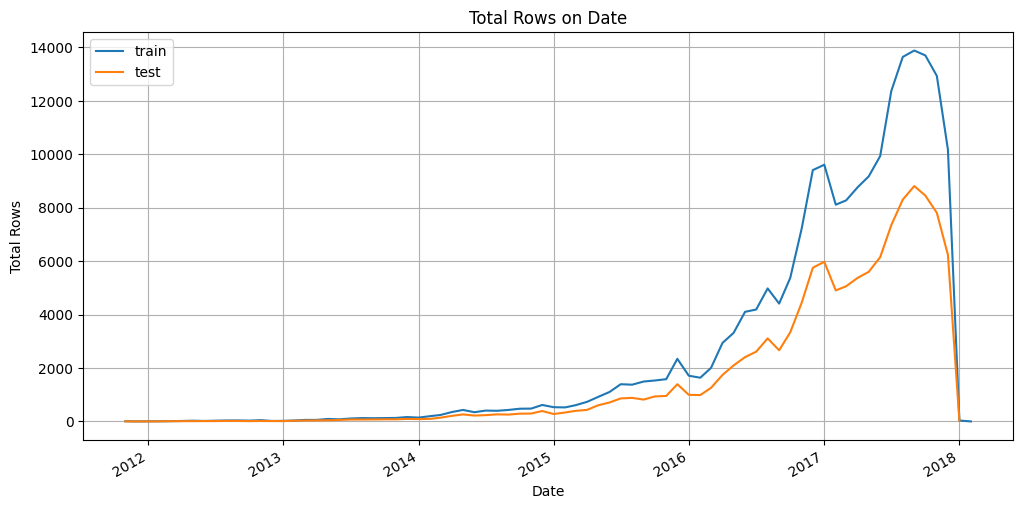

In [14]:
# Group the DataFrame by 'first_active_month' and count the number of rows in each group
date_counts_train = train.groupby('first_active_month').size()
date_counts_test = test.groupby('first_active_month').size()

# Create a time series plot
plt.figure(figsize=(12, 6))
date_counts_train.plot(label='train')
date_counts_test.plot(label='test')
plt.title('Total Rows on Date')
plt.xlabel('Date')
plt.ylabel('Total Rows')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_21/1903071837.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(range(-1, 15, 2))


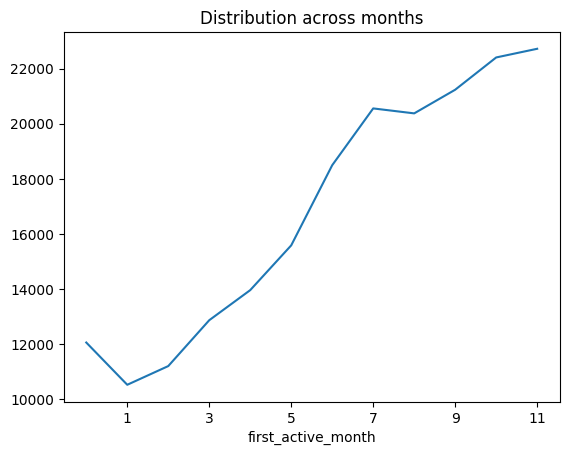

In [15]:
temp = train['first_active_month'].dt.month.value_counts().sort_index()
ax = temp.plot()
_ = ax.set_xticklabels(range(-1, 15, 2))
_ = ax.set_title("Distribution across months")

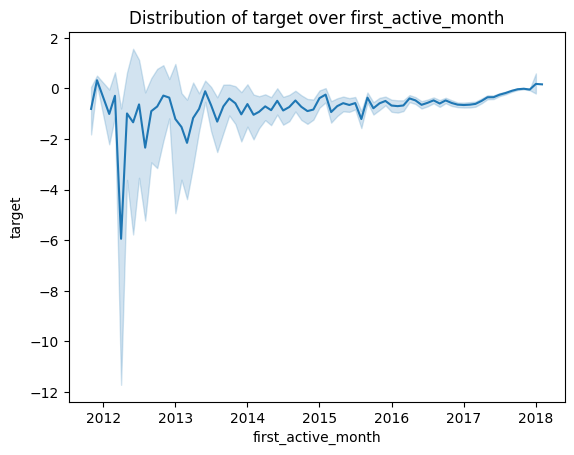

In [16]:
sns.lineplot(x = train['first_active_month'], y= train['target'])
plt.title("Distribution of target over first_active_month")
plt.show()

In [17]:
historical_data = pd.merge(historical_transactions, train[['card_id','target']], how = 'outer', on = 'card_id')

# merging target value of card_id for each transction in new_merchants_transactions Data
new_data =  pd.merge(new_transactions, train[['card_id','target']], how = 'outer', on = 'card_id')

In [18]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       int64         
 1   card_id               object        
 2   city_id               int64         
 3   category_1            int64         
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
 14  target                float64       
dtypes: datetime64[ns](1), float64(3), int64(8), object(3)
memory usage: 3.3+ GB


In [19]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984962 entries, 0 to 1984961
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       float64       
 1   card_id               object        
 2   city_id               float64       
 3   category_1            float64       
 4   installments          float64       
 5   category_3            object        
 6   merchant_category_id  float64       
 7   merchant_id           object        
 8   month_lag             float64       
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              float64       
 13  subsector_id          float64       
 14  target                float64       
dtypes: datetime64[ns](1), float64(11), object(3)
memory usage: 227.2+ MB


Text(0.5, 1.0, 'New Transactions Correlation Matrix')

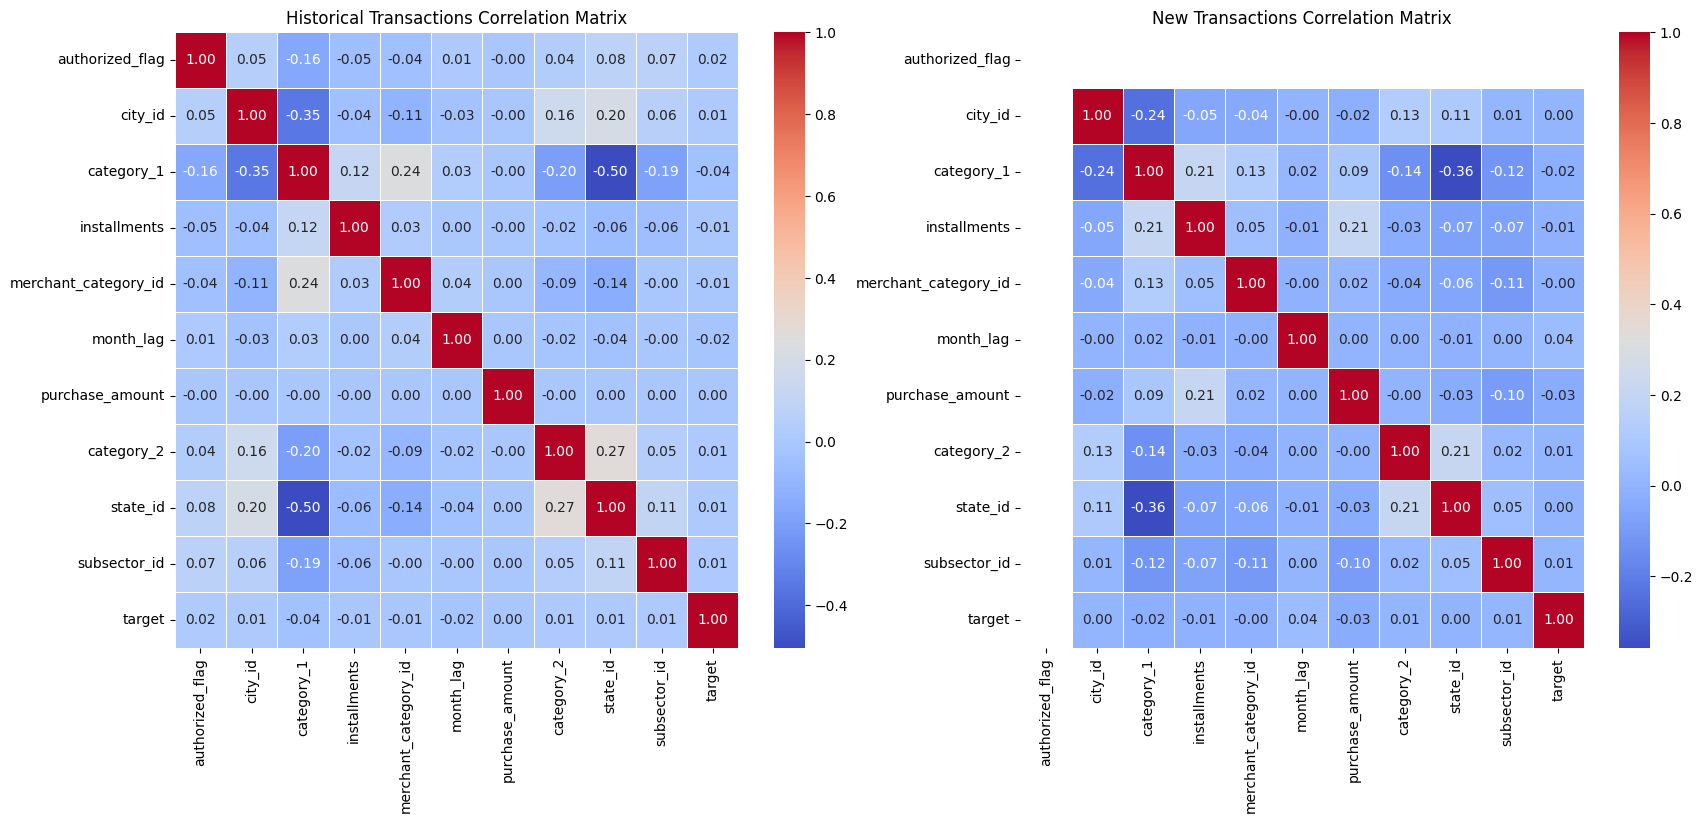

In [20]:
historical_numeric_df = historical_data.select_dtypes(include=['number'])
new_numeric_df = new_data.select_dtypes(include=['number'])

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# First subplot
historical_correlation_matrix = historical_numeric_df .corr()
sns.heatmap(historical_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Historical Transactions Correlation Matrix')

# Second subplot
new_correlation_matrix = new_numeric_df.corr()
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title('New Transactions Correlation Matrix')

In [21]:
#delete variables for EDA to save momories
del historical_numeric_df,new_numeric_df,fig,axes ,historical_correlation_matrix,new_correlation_matrix,historical_data,new_data ,temp,ax,date_counts_train,date_counts_test

<a id="2"></a> <br>
## Feature engineering
Following [Chau Ngoc Huynh's kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/), I add the following features:

In [22]:
e = pd.read_excel('/kaggle/input/elo-merchant-category-recommendation/Data Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [23]:
target = train['target']
del train['target']

In [24]:
datetime.datetime.today()
datetime.datetime(2018, 11, 27)

datetime.datetime(2018, 11, 27, 0, 0)

In [25]:
historical_transactions['month_diff'] = ((datetime.datetime(2018, 11, 27) - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime(2018, 11, 27) - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

#hoidays source https://www.officeholidays.com/countries/brazil/2017 , https://www.officeholidays.com/countries/brazil/2018 
#including Christmas Eve, New Year's Eve and Black Awareness Day
holiday_dates = pd.to_datetime( ['01-01-2017','27-02-2017','28-02-2017','01-02-2017','14-04-2017','21-04-2017','01-05-2017','15-06-2017','07-09-2017',
                    '12-10-2017','01-11-2017','02-11-2017','15-11-2017','20-11-2017','24-12-2017','25-12-2017','31-12-2017',
                    '01-01-2018', '12-02-2018', '13-02-2018','30-03-2018','21-04-2018','01-05-2018','31-05-2018','07-09-2018',
                    '12-10-2018','02-11-2018','15-11-2018','20-11-2018','24-12-2018','25-12-2018','31-12-2018'] ,format="%d-%m-%Y")

historical_transactions["holiday_purchase"] = np.where(historical_transactions["purchase_date"].isin(holiday_dates) , 1, 0)
new_transactions["holiday_purchase"] = np.where(new_transactions["purchase_date"].isin(holiday_dates) , 1, 0)

In [26]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff,holiday_purchase
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,9,0
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,9,0
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14,9,0
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,1.0,-1,8,9,0
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,1.0,-1,29,9,0


In [27]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff,holiday_purchase
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,9,0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,9,0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,9,0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,10,0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,9,0


In [28]:

#Convert categorical variable into dummy/indicator variables.
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])


historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)


agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)


authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1360.42 Mb (59.2% reduction)
Mem. usage decreased to 87.99 Mb (60.8% reduction)


In [29]:
historical_transactions[:5] 

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,holiday_purchase,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,9,0,True,False,False,False,False,True,False,False
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,9,0,True,False,False,False,False,True,False,False
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,9,0,True,False,False,False,False,True,False,False
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,9,0,True,False,False,False,False,True,False,False
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,9,0,True,False,False,False,False,True,False,False


In [30]:
authorized_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,holiday_purchase,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,9,0,True,False,False,False,False,True,False,False
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,9,0,True,False,False,False,False,True,False,False
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,9,0,True,False,False,False,False,True,False,False
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,10,0,True,False,False,False,False,True,False,False
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,9,0,True,False,False,False,False,True,False,False


First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [31]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [32]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['count','sum', 'mean'],
    'category_2_1.0': ['count','sum','mean'],
    'category_2_2.0': ['count','sum','mean'],
    'category_2_3.0': ['count','sum','mean'],
    'category_2_4.0': ['count','sum','mean'],
    'category_2_5.0': ['count','sum','mean'],
    'category_3_A': ['count','sum','mean'],
    'category_3_B': ['count','sum','mean'],
    'category_3_C': ['count','sum','mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean','max', 'min', 'std'],
    'holiday_purchase' : ['count','sum','mean'],
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history



In [33]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_count,hist_category_2_1.0_sum,hist_category_2_1.0_mean,hist_category_2_2.0_count,hist_category_2_2.0_sum,hist_category_2_2.0_mean,hist_category_2_3.0_count,hist_category_2_3.0_sum,hist_category_2_3.0_mean,hist_category_2_4.0_count,hist_category_2_4.0_sum,hist_category_2_4.0_mean,hist_category_2_5.0_count,hist_category_2_5.0_sum,hist_category_2_5.0_mean,hist_category_3_A_count,hist_category_3_A_sum,hist_category_3_A_mean,hist_category_3_B_count,hist_category_3_B_sum,hist_category_3_B_mean,hist_category_3_C_count,hist_category_3_C_sum,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std,hist_holiday_purchase_count,hist_holiday_purchase_sum,hist_holiday_purchase_mean
0,C_ID_00007093c1,35,35,4,0.114286,35,4,0.114286,35,0,0.000000,35,31,0.885714,35,0,0.0,35,0,0.000000,35,0,0.000000,35,29,0.828571,35,6,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,9.028571,10,9,0.169031,35,0,0.0
1,C_ID_0001238066,3,3,0,0.000000,3,1,0.333333,3,0,0.000000,3,0,0.000000,3,0,0.0,3,2,0.666667,3,0,0.000000,3,3,1.000000,3,0,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,9.000000,9,9,0.000000,3,0,0.0
2,C_ID_0001506ef0,4,4,0,0.000000,4,0,0.000000,4,0,0.000000,4,4,1.000000,4,0,0.0,4,0,0.000000,4,3,0.750000,4,1,0.250000,4,0,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,9.000000,9,9,0.000000,4,0,0.0
3,C_ID_0001793786,27,27,2,0.074074,27,16,0.592593,27,8,0.296296,27,3,0.111111,27,0,0.0,27,0,0.000000,27,22,0.814815,27,5,0.185185,27,0,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,13.148148,14,13,0.362014,27,0,0.0
4,C_ID_000183fdda,7,7,0,0.000000,7,0,0.000000,7,0,0.000000,7,7,1.000000,7,0,0.0,7,0,0.000000,7,0,0.000000,7,3,0.428571,7,4,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,9.000000,9,9,0.000000,7,0,0.0


In [34]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_count,auth_category_2_1.0_sum,auth_category_2_1.0_mean,auth_category_2_2.0_count,auth_category_2_2.0_sum,auth_category_2_2.0_mean,auth_category_2_3.0_count,auth_category_2_3.0_sum,auth_category_2_3.0_mean,auth_category_2_4.0_count,auth_category_2_4.0_sum,auth_category_2_4.0_mean,auth_category_2_5.0_count,auth_category_2_5.0_sum,auth_category_2_5.0_mean,auth_category_3_A_count,auth_category_3_A_sum,auth_category_3_A_mean,auth_category_3_B_count,auth_category_3_B_sum,auth_category_3_B_mean,auth_category_3_C_count,auth_category_3_C_sum,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,auth_month_diff_std,auth_holiday_purchase_count,auth_holiday_purchase_sum,auth_holiday_purchase_mean
0,C_ID_00007093c1,114,114,24,0.210526,114,24,0.210526,114,0,0.000000,114,89,0.780702,114,0,0.0,114,1,0.008772,114,0,0.000000,114,96,0.842105,114,18,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,9.166667,10,9,0.374323,114,0,0.000000
1,C_ID_0001238066,120,120,2,0.016667,120,102,0.850000,120,0,0.000000,120,0,0.000000,120,0,0.0,120,18,0.150000,120,3,0.025000,120,85,0.708333,120,32,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,9.008333,10,9,0.091287,120,1,0.008333
2,C_ID_0001506ef0,62,62,0,0.000000,62,2,0.032258,62,0,0.000000,62,60,0.967742,62,0,0.0,62,0,0.000000,62,62,1.000000,62,0,0.000000,62,0,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,9.112903,10,9,0.319058,62,0,0.000000
3,C_ID_0001793786,189,189,0,0.000000,189,109,0.576720,189,68,0.359788,189,12,0.063492,189,0,0.0,189,0,0.000000,189,189,1.000000,189,0,0.000000,189,0,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,13.116402,14,13,0.321558,189,0,0.000000
4,C_ID_000183fdda,137,137,4,0.029197,137,11,0.080292,137,1,0.007299,137,124,0.905109,137,0,0.0,137,1,0.007299,137,4,0.029197,137,100,0.729927,137,33,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,9.000000,10,8,0.242536,137,0,0.000000


In [35]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_count,new_category_2_1.0_sum,new_category_2_1.0_mean,new_category_2_2.0_count,new_category_2_2.0_sum,new_category_2_2.0_mean,new_category_2_3.0_count,new_category_2_3.0_sum,new_category_2_3.0_mean,new_category_2_4.0_count,new_category_2_4.0_sum,new_category_2_4.0_mean,new_category_2_5.0_count,new_category_2_5.0_sum,new_category_2_5.0_mean,new_category_3_A_count,new_category_3_A_sum,new_category_3_A_mean,new_category_3_B_count,new_category_3_B_sum,new_category_3_B_mean,new_category_3_C_count,new_category_3_C_sum,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,new_month_diff_max,new_month_diff_min,new_month_diff_std,new_holiday_purchase_count,new_holiday_purchase_sum,new_holiday_purchase_mean
0,C_ID_00007093c1,2,2,0,0.000000,2,1,0.500000,2,0,0.000000,2,1,0.50000,2,0,0.0,2,0,0.000000,2,0,0.000000,2,2,1.000000,2,0,0.000000,2,2,2,2,2,-1.328613,-0.664307,-0.656738,-0.671875,0.010703,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,9.000000,9,9,0.000000,2,0,0.0
1,C_ID_0001238066,26,26,2,0.076923,26,23,0.884615,26,0,0.000000,26,0,0.00000,26,0,0.0,26,3,0.115385,26,1,0.038462,26,21,0.807692,26,4,0.153846,25,15,4,8,9,-14.850159,-0.571160,-0.078308,-0.740723,0.173412,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,9.038462,10,9,0.196116,26,0,0.0
2,C_ID_0001506ef0,2,2,0,0.000000,2,0,0.000000,2,0,0.000000,2,2,1.00000,2,0,0.0,2,0,0.000000,2,2,1.000000,2,0,0.000000,2,0,0.000000,2,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011739,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,9.000000,9,9,0.000000,2,0,0.0
3,C_ID_0001793786,31,31,0,0.000000,31,17,0.548387,31,8,0.258065,31,5,0.16129,31,0,0.0,31,1,0.032258,31,31,1.000000,31,0,0.000000,31,0,0.000000,31,21,5,7,14,-0.229002,-0.007387,3.130859,-0.737793,0.947299,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,13.000000,13,13,0.000000,31,0,0.0
4,C_ID_000183fdda,11,11,0,0.000000,11,0,0.000000,11,0,0.000000,11,11,1.00000,11,0,0.0,11,0,0.000000,11,1,0.090909,11,6,0.545455,11,4,0.363636,11,9,2,2,6,-6.590820,-0.599165,-0.107666,-0.732422,0.182870,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,9.000000,9,9,0.000000,11,0,0.0


The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [36]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]


,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496068,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316093,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557396,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u



In [38]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')



In [39]:
#Grouping month lag data (auth month-13, auth month-12 and etc.) for count purchases, and sum adjusted purchase_amount, std, min, max)

def aggregate_date(history):

    grouped = history.groupby(['card_id','purchase_date'])

    agg_func = {
            'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
            'installments': ['sum', 'mean', 'min', 'max', 'std'],
             }
 

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]

    intermediate_group.reset_index(inplace=True)
    final_group = intermediate_group.groupby('card_id').agg(['mean','std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
x =  aggregate_date(historical_transactions) 
x[:10]


,card_id,purchase_date_mean,purchase_date_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,1.502751e+09,9.092175e+06,-0.411485,0.430059,-0.411485,0.430059,-0.411485,0.430059,-0.411485,0.430059,NaN,NaN,1.285714,0.667367,1.285714,0.667367,1.285714,0.667367,1.285714,0.667367,NaN,NaN
1,C_ID_0001238066,1.515863e+09,2.083731e+06,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN
2,C_ID_0001506ef0,1.511659e+09,1.031806e+07,-0.726445,0.016203,-0.726445,0.016203,-0.726445,0.016203,-0.726445,0.016203,NaN,NaN,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,0.250000,0.500000,NaN,NaN
3,C_ID_0001793786,1.498788e+09,6.491738e+06,-0.437975,0.498150,-0.437975,0.498150,-0.437975,0.498150,-0.437975,0.498150,NaN,NaN,0.185185,0.395847,0.185185,0.395847,0.185185,0.395847,0.185185,0.395847,NaN,NaN
4,C_ID_000183fdda,1.504129e+09,2.262857e+06,-0.134483,0.452741,-0.134483,0.452741,-0.134483,0.452741,-0.134483,0.452741,NaN,NaN,2.714286,2.288689,2.714286,2.288689,2.714286,2.288689,2.714286,2.288689,NaN,NaN
5,C_ID_00024e244b,1.506548e+09,8.501619e+06,-0.488624,0.415206,-0.488624,0.415206,-0.488624,0.415206,-0.488624,0.415206,NaN,NaN,0.294118,0.469668,0.294118,0.469668,0.294118,0.469668,0.294118,0.469668,NaN,NaN
6,C_ID_0002709b5a,1.504874e+09,1.350371e+07,-0.619783,0.135662,-0.619783,0.135662,-0.619783,0.135662,-0.619783,0.135662,NaN,NaN,1.833333,2.041241,1.833333,2.041241,1.833333,2.041241,1.833333,2.041241,NaN,NaN
7,C_ID_00027503e2,1.504394e+09,6.988880e+06,-0.741570,0.003383,-0.741570,0.003383,-0.741570,0.003383,-0.741570,0.003383,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
8,C_ID_000298032a,1.499012e+09,1.014387e+07,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,1.501473e+09,7.469866e+06,-0.618979,0.105717,-0.618979,0.105717,-0.618979,0.105717,-0.618979,0.105717,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


In [40]:
y =  aggregate_date(authorized_transactions) 

<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [41]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, x, on='card_id', how='left')
test = pd.merge(test,x, on='card_id', how='left')

train = pd.merge(train, y, on='card_id', how='left')
test = pd.merge(test,y, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [42]:
train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

/tmp/ipykernel_21/2425621244.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
/tmp/ipykernel_21/2425621244.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']


and to define the features we want to keep to train the model. For that purpose, I use the results obtained in the [Selecting features kernel](https://www.kaggle.com/fabiendaniel/selecting-features/notebook):

In [43]:

features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
cols_remove = ['card_id', 'first_active_month']
for col in cols_remove:  
    del train[col]

del test['first_active_month']

In [44]:
numerical = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

# Get discrete var
discrete= []
for var in numerical:
    if len(train[var].unique())<8:
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

continuous = [var for var in numerical if var not in discrete and var not in ['card_id', 'first_active_month','target']]
print('There are {} continuous variables'.format(len(continuous)))

There are 275 numerical variables
There are 6 discrete variables
There are 269 continuous variables


In [45]:
categorical_feats =discrete

In [46]:
for col in features:
    if col in continuous:
        train[col] = train[col].fillna(value = train[col].mean())
        test[col] = test[col].fillna(value = test[col].mean())


In [47]:
from sklearn.impute import SimpleImputer
import numpy as np
train_null = train.columns[train.isnull().any()].tolist()
test_null = test.columns[test.isnull().any()].tolist()

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train[train_null] =imp.fit_transform(train[train_null])
test[test_null] =imp.fit_transform(test[test_null])

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [48]:
from sklearn.model_selection import RepeatedKFold,StratifiedKFold
from sklearn.linear_model import Ridge, BayesianRidge
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2023)
oof_ridge = np.zeros(train.shape[0])
predictions_ridge = np.zeros(test.shape[0])

tst_data = test.copy()

tst_data = tst_data[features].values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target)):
    print("fold n°{}".format(fold_+1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values

    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(tst_data) / 10

np.save('oof_ridge', oof_ridge)
np.save('predictions_ridge', predictions_ridge)
np.sqrt(mean_squared_error(target.values, oof_ridge))

fold n°1


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°2


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°3


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°4


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°5


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°6


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°7


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°8


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°9


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


fold n°10


/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1497: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


3.779034028941778

[](http://)

In [49]:
import xgboost as xgb

xgb_params = {'eta': 0.005, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'random_state':2023}


folds = RepeatedKFold(n_splits=3, n_repeats=1, random_state=2023)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 6000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)

    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), iteration_range=(0, xgb_model.best_iteration))
    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), iteration_range=(0, xgb_model.best_iteration)) / folds.get_n_splits()
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
print("RMSE : ",np.sqrt(mean_squared_error(target.values, oof_xgb)))



fold n°1
xgb 0--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:52:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:52:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:3.83184	valid-rmse:3.88132
[1000]	train-rmse:3.02040	valid-rmse:3.69611
[1055]	train-rmse:3.00166	valid-rmse:3.69616
fold n°2
xgb 1--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:56:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:56:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:3.86192	valid-rmse:3.82154
[844]	train-rmse:3.11989	valid-rmse:3.64048
fold n°3
xgb 2--------------------------------------------------


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:59:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:59:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:3.85045	valid-rmse:3.84409
[875]	train-rmse:3.10286	valid-rmse:3.66019
RMSE :  3.665595558819854


In [50]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. **The variations observed on the CV were found to be quite similar to the variations on the LB**: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [51]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    early_stopping_rounds = 200
    callbacks =  [lgb.early_stopping(early_stopping_rounds, first_metric_only=False, verbose=True)]
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    callbacks=callbacks)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1774]	training's rmse: 3.40926	valid_1's rmse: 3.67524
fold n°1


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1521]	training's rmse: 3.44432	valid_1's rmse: 3.61321
fold n°2


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1896]	training's rmse: 3.4115	valid_1's rmse: 3.59383
fold n°3


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1210]	training's rmse: 3.42796	valid_1's rmse: 3.78224
fold n°4


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1386]	training's rmse: 3.4554	valid_1's rmse: 3.6121
CV score: 3.65598 


In [52]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import  Lasso
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tqdm import tqdm

catboost_model = CatBoostRegressor(iterations=130)
rf_model = RandomForestRegressor(max_depth = 20,n_estimators=20, min_samples_leaf=20, min_samples_split=20)
knn_model = KNeighborsRegressor(n_neighbors=15, weights='distance')
ridge_model = Ridge(alpha=75.0)
lasso_model = Lasso(alpha=0.7)



In [53]:
models = [
     ('CatBoost', catboost_model),
     ('RandomForest', rf_model),
     ('Lasso', lasso_model),
     ('KNN', knn_model),
]

def rmse_fun(predicted, actual):
    return mean_squared_error(predicted, actual)**0.5

rmse = make_scorer(rmse_fun, greater_is_better=False)
scores = []
for _,model in tqdm(models):
    print(model)
    score = -1* cross_val_score(model, train.values, target.values,cv=4, scoring=rmse).mean()
    print(score)
    scores.append(score)

  0%|          | 0/4 [00:00<?, ?it/s]

Learning rate set to 0.475357
0:	learn: 3.7619904	total: 233ms	remaining: 30s
1:	learn: 3.7232724	total: 387ms	remaining: 24.8s
2:	learn: 3.7041375	total: 540ms	remaining: 22.8s
3:	learn: 3.6923277	total: 673ms	remaining: 21.2s
4:	learn: 3.6857455	total: 847ms	remaining: 21.2s
5:	learn: 3.6809326	total: 966ms	remaining: 20s
6:	learn: 3.6755406	total: 1.12s	remaining: 19.7s
7:	learn: 3.6708477	total: 1.26s	remaining: 19.2s
8:	learn: 3.6642414	total: 1.41s	remaining: 19s
9:	learn: 3.6619574	total: 1.55s	remaining: 18.6s
10:	learn: 3.6589106	total: 1.68s	remaining: 18.2s
11:	learn: 3.6521525	total: 1.85s	remaining: 18.2s
12:	learn: 3.6517591	total: 1.95s	remaining: 17.5s
13:	learn: 3.6486399	total: 2.11s	remaining: 17.5s
14:	learn: 3.6452673	total: 2.26s	remaining: 17.3s
15:	learn: 3.6433410	total: 2.39s	remaining: 17s
16:	learn: 3.6396770	total: 2.5s	remaining: 16.6s
17:	learn: 3.6377033	total: 2.67s	remaining: 16.6s
18:	learn: 3.6343243	total: 2.82s	remaining: 16.5s
19:	learn: 3.6313653

 25%|██▌       | 1/4 [03:28<10:24, 208.33s/it]

3.719225746458277
RandomForestRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=20,
                      n_estimators=20)


 50%|█████     | 2/4 [39:42<45:29, 1364.89s/it]

3.6919891189850036
Lasso(alpha=0.7)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.034e+05, tolerance: 2.235e+02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.585e+05, tolerance: 2.261e+02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.277e+05, tolerance: 2.280e

3.8340200119772883
KNeighborsRegressor(n_neighbors=15, weights='distance')


100%|██████████| 4/4 [54:29<00:00, 817.39s/it]

3.8878111312612114


In [54]:
scores

[3.719225746458277, 3.6919891189850036, 3.8340200119772883, 3.8878111312612114]

<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

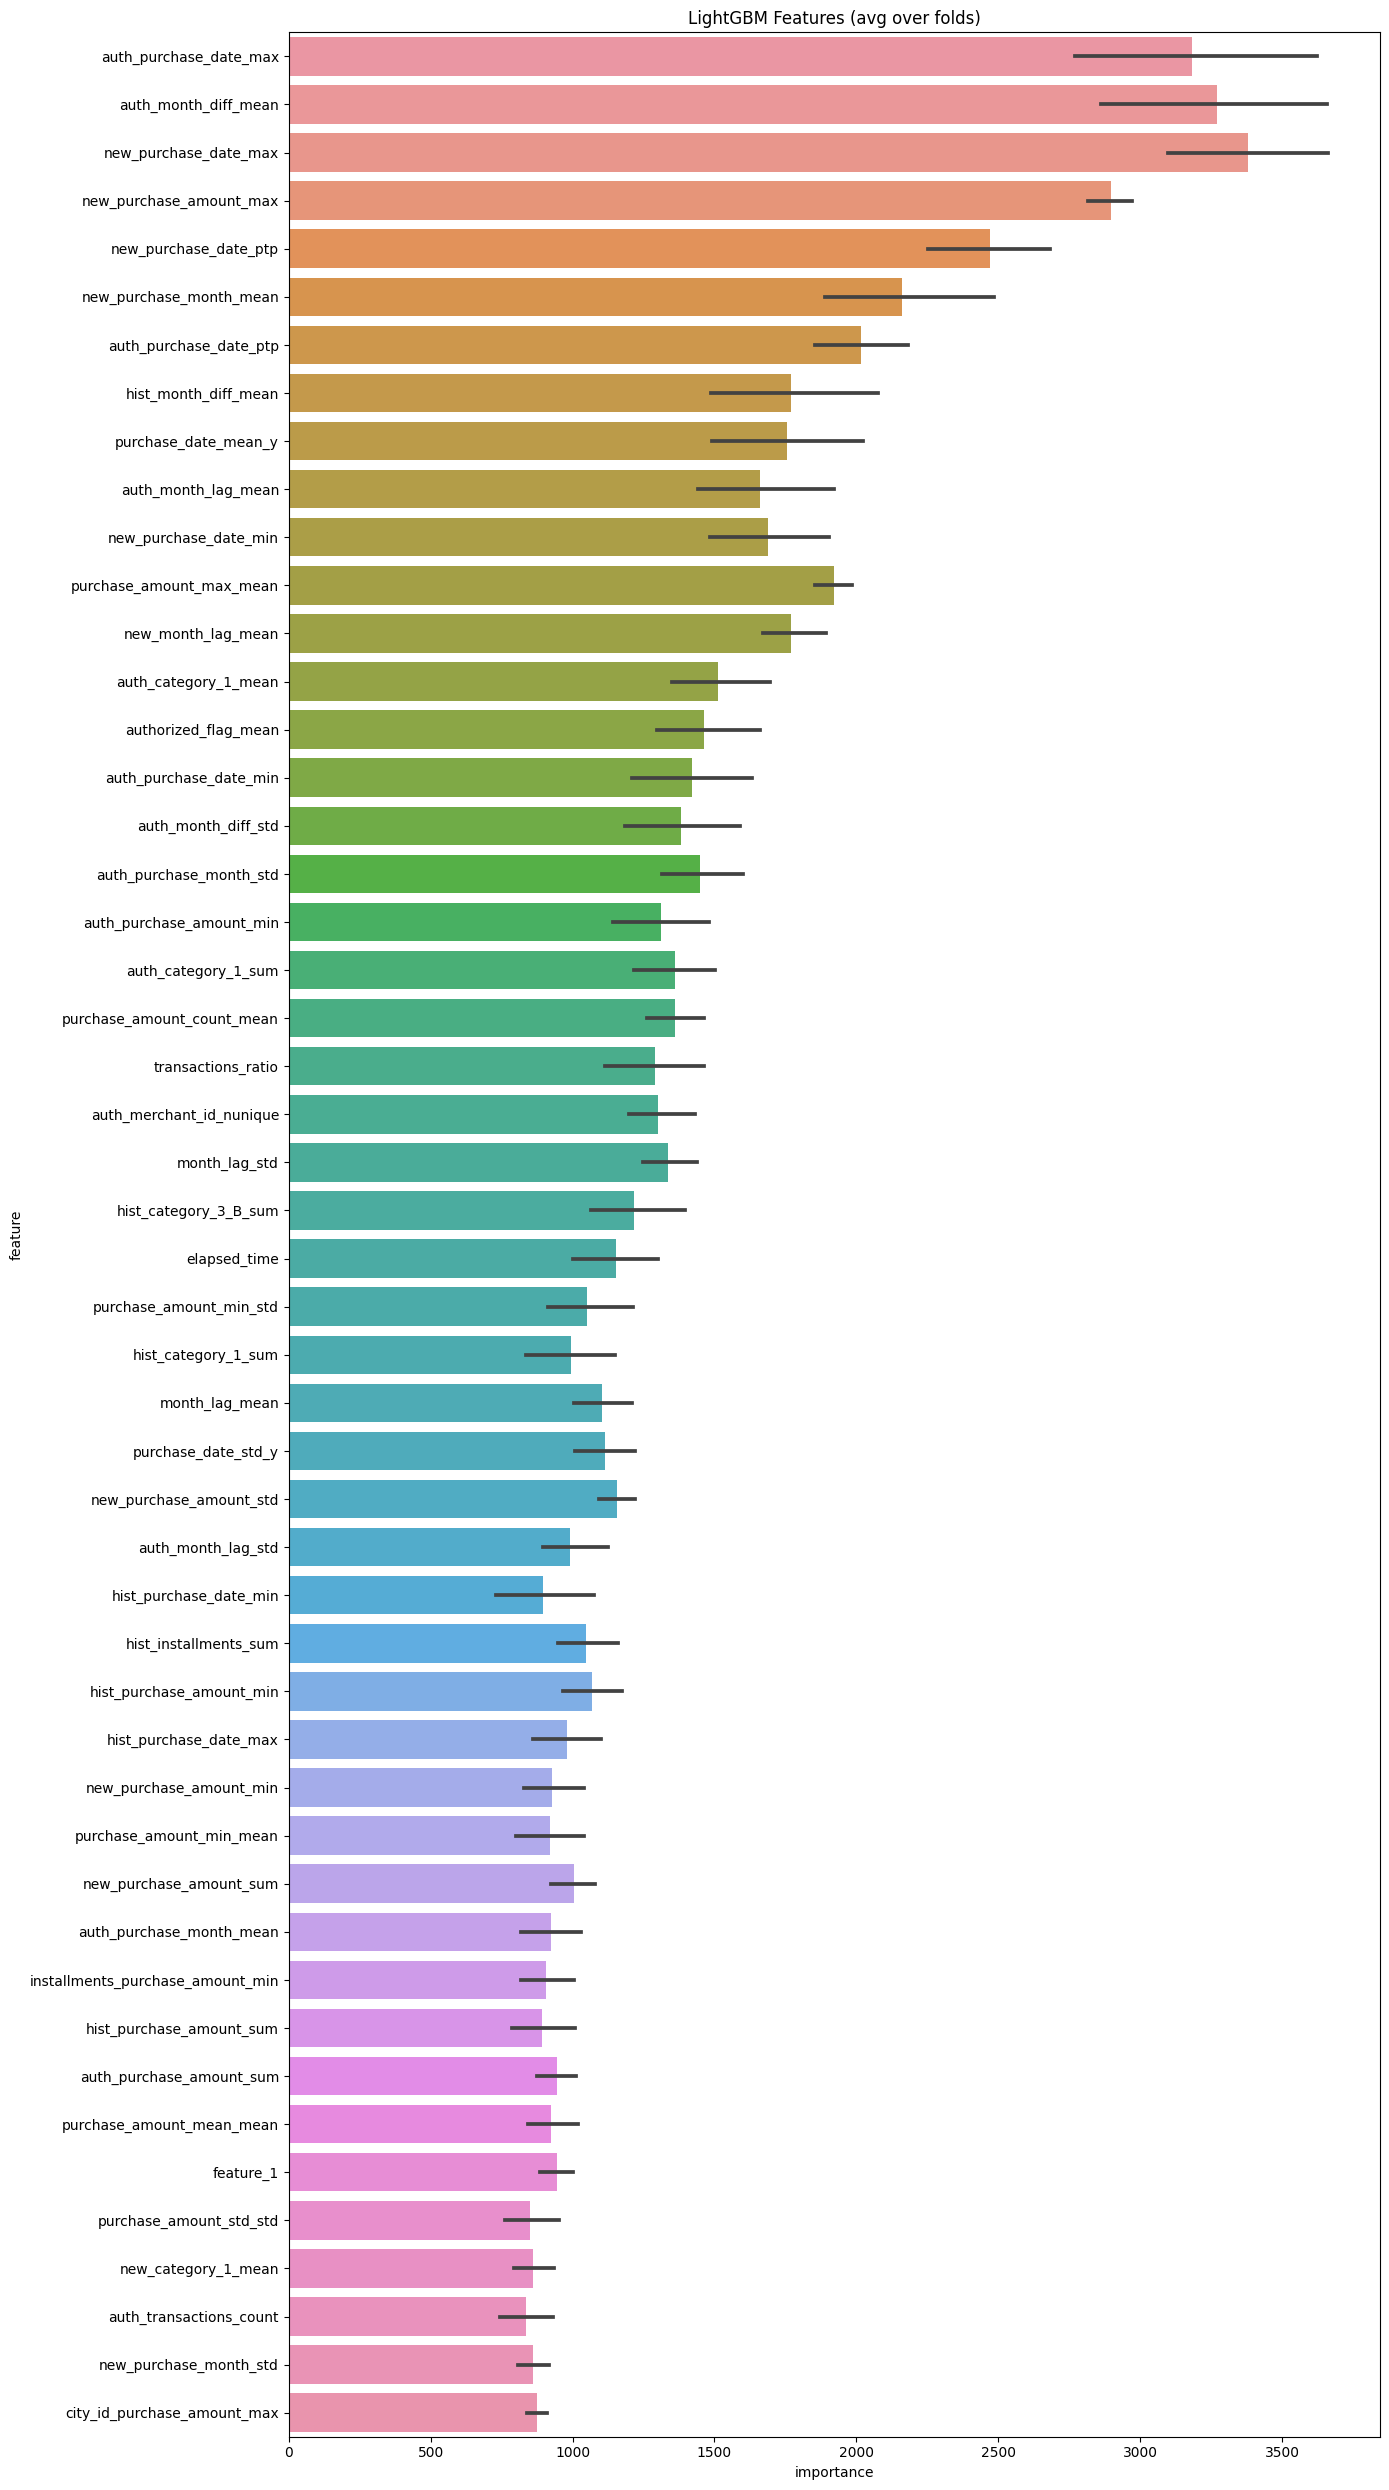

In [55]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [56]:
train_stack = np.vstack([oof_ridge, oof, oof_xgb]).transpose()
test_stack = np.vstack([predictions_ridge, predictions,predictions_xgb]).transpose()

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Ridge Regression" + str(fold_) + "-" * 10)
    clf = Ridge(alpha=75)
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


fold n°0
----------Ridge Regression0----------
fold n°1
----------Ridge Regression1----------
fold n°2
----------Ridge Regression2----------
fold n°3
----------Ridge Regression3----------
fold n°4
----------Ridge Regression4----------


In [57]:
models = [
    'CatBoost',
    'RandomForest',
    'Lasso',
    'KNN',
    'LGB',
    'Ridge',
    'XGB',
    'Stack']
r = [np.sqrt(mean_squared_error(oof, target)),np.sqrt(mean_squared_error(oof_ridge, target)),np.sqrt(mean_squared_error(oof_xgb, target)),np.sqrt(mean_squared_error(oof_stack, target))]
scores+= r                                                                                         
                                                                                        

In [58]:
df = pd.DataFrame({ 'Model': models, 'Error': scores })
df

,Model,Error
0,CatBoost,3.719226
1,RandomForest,3.691989
2,Lasso,3.834020
3,KNN,3.887811
4,LGB,3.655977
5,Ridge,3.779034
6,XGB,3.665596
7,Stack,3.654918


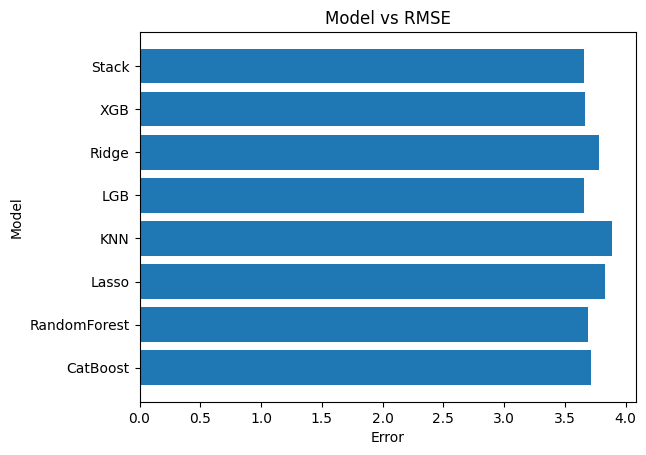

In [59]:
import pandas as pd

plt.barh(df['Model'], df['Error'])
plt.title('Model vs RMSE')
plt.ylabel('Model')
plt.xlabel('Error')
plt.show()

In [60]:
test1 = test.copy()
del test1['card_id']

In [61]:

catboost_model.fit(train.values, target.values) 
predictions_cat = catboost_model.predict(test1.values)

Learning rate set to 0.497463
0:	learn: 3.7714741	total: 248ms	remaining: 31.9s
1:	learn: 3.7261818	total: 424ms	remaining: 27.2s
2:	learn: 3.7083791	total: 631ms	remaining: 26.7s
3:	learn: 3.6941087	total: 816ms	remaining: 25.7s
4:	learn: 3.6864289	total: 965ms	remaining: 24.1s
5:	learn: 3.6820229	total: 1.1s	remaining: 22.8s
6:	learn: 3.6748856	total: 1.3s	remaining: 22.9s
7:	learn: 3.6716684	total: 1.54s	remaining: 23.5s
8:	learn: 3.6703869	total: 1.73s	remaining: 23.3s
9:	learn: 3.6676639	total: 1.97s	remaining: 23.6s
10:	learn: 3.6652863	total: 2.19s	remaining: 23.7s
11:	learn: 3.6613557	total: 2.44s	remaining: 24s
12:	learn: 3.6574755	total: 2.74s	remaining: 24.7s
13:	learn: 3.6543465	total: 2.97s	remaining: 24.6s
14:	learn: 3.6495219	total: 3.18s	remaining: 24.4s
15:	learn: 3.6478540	total: 3.32s	remaining: 23.7s
16:	learn: 3.6456623	total: 3.53s	remaining: 23.5s
17:	learn: 3.6429540	total: 3.7s	remaining: 23s
18:	learn: 3.6405629	total: 3.85s	remaining: 22.5s
19:	learn: 3.63782

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [62]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_xgb
sub_df.to_csv("submit1.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_stack
sub_df.to_csv("submit2.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_cat
sub_df.to_csv("submit3.csv", index=False)

In [63]:
#[1050]	training's rmse: 3.47865	valid_1's rmse: 3.61203     CV score: 3.65527 